# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 9, 14, 5, 52, 900803)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1161365
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.8903494E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-10 00:00:00+00:00,20.650000,0.0,4.334974,355.236450,alicante
1,2024-11-18 00:00:00+00:00,18.000000,0.0,18.847641,298.523010,alicante
2,2024-11-15 00:00:00+00:00,16.299999,0.0,10.464797,310.814972,alicante
3,2024-11-14 00:00:00+00:00,16.549999,0.0,12.574260,293.629395,alicante
4,2024-11-16 00:00:00+00:00,16.650000,0.0,21.829777,283.348724,alicante
5,2024-11-12 00:00:00+00:00,20.500000,0.0,7.928178,272.602509,alicante
6,2024-11-17 00:00:00+00:00,17.900000,0.0,18.129137,276.842682,alicante
7,2024-11-11 00:00:00+00:00,20.000000,0.0,13.397612,83.829926,alicante
8,2024-11-13 00:00:00+00:00,11.000000,2.0,16.870138,309.805511,alicante


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-10 00:00:00+00:00,20.650000,0.0,4.334974,355.236450,alicante,7.103600
1,2024-11-18 00:00:00+00:00,18.000000,0.0,18.847641,298.523010,alicante,1.591817
2,2024-11-15 00:00:00+00:00,16.299999,0.0,10.464797,310.814972,alicante,8.137086
3,2024-11-14 00:00:00+00:00,16.549999,0.0,12.574260,293.629395,alicante,11.249186
4,2024-11-16 00:00:00+00:00,16.650000,0.0,21.829777,283.348724,alicante,2.327883
5,2024-11-12 00:00:00+00:00,20.500000,0.0,7.928178,272.602509,alicante,9.172248
6,2024-11-17 00:00:00+00:00,17.900000,0.0,18.129137,276.842682,alicante,1.923564
7,2024-11-11 00:00:00+00:00,20.000000,0.0,13.397612,83.829926,alicante,4.079685
8,2024-11-13 00:00:00+00:00,11.000000,2.0,16.870138,309.805511,alicante,10.300935


In [9]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-10 00:00:00+00:00,20.650000,0.0,4.334974,355.236450,alicante,7.103600,"Cl Pp Cds Kalmias, Moraira",spain,1
7,2024-11-11 00:00:00+00:00,20.000000,0.0,13.397612,83.829926,alicante,4.079685,"Cl Pp Cds Kalmias, Moraira",spain,8
5,2024-11-12 00:00:00+00:00,20.500000,0.0,7.928178,272.602509,alicante,9.172248,"Cl Pp Cds Kalmias, Moraira",spain,6
8,2024-11-13 00:00:00+00:00,11.000000,2.0,16.870138,309.805511,alicante,10.300935,"Cl Pp Cds Kalmias, Moraira",spain,9
3,2024-11-14 00:00:00+00:00,16.549999,0.0,12.574260,293.629395,alicante,11.249186,"Cl Pp Cds Kalmias, Moraira",spain,4
2,2024-11-15 00:00:00+00:00,16.299999,0.0,10.464797,310.814972,alicante,8.137086,"Cl Pp Cds Kalmias, Moraira",spain,3
4,2024-11-16 00:00:00+00:00,16.650000,0.0,21.829777,283.348724,alicante,2.327883,"Cl Pp Cds Kalmias, Moraira",spain,5
6,2024-11-17 00:00:00+00:00,17.900000,0.0,18.129137,276.842682,alicante,1.923564,"Cl Pp Cds Kalmias, Moraira",spain,7
1,2024-11-18 00:00:00+00:00,18.000000,0.0,18.847641,298.523010,alicante,1.591817,"Cl Pp Cds Kalmias, Moraira",spain,2


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 1
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   country                      9 non-null      object             
 9   days_before_forecast_day     9 non-null      int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), object(3)


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-09 14:08:00,163 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



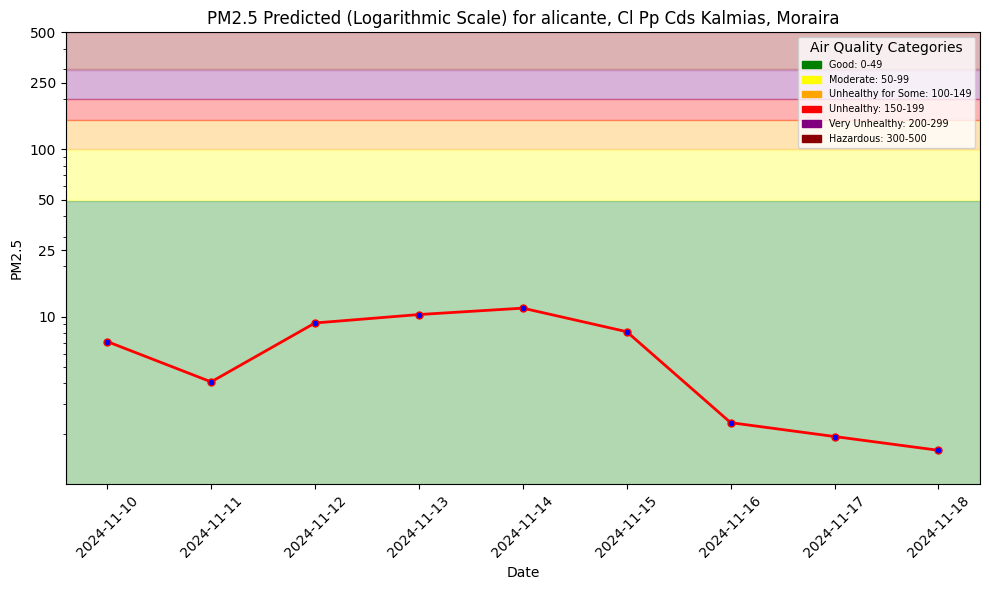

In [12]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.97s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-10 00:00:00+00:00,20.65,0.0,4.334974,355.236450,alicante,7.103600,"Cl Pp Cds Kalmias, Moraira",spain,1
1,2024-11-09 00:00:00+00:00,23.25,0.0,21.422270,294.842346,alicante,2.856916,"Cl Pp Cds Kalmias, Moraira",spain,1


In [19]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.58s) 


,date,pm25,country,city,street,url
0,2021-06-29 00:00:00+00:00,6.10,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
1,2021-10-13 00:00:00+00:00,4.37,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
2,2023-09-29 00:00:00+00:00,3.10,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
3,2021-08-15 00:00:00+00:00,8.74,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
4,2023-09-18 00:00:00+00:00,3.30,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
...,...,...,...,...,...,...
1767,2021-07-05 00:00:00+00:00,8.69,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
1768,2020-01-22 00:00:00+00:00,4.49,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
1769,2020-07-04 00:00:00+00:00,3.60,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504
1770,2020-07-18 00:00:00+00:00,3.40,spain,alicante,"Cl Pp Cds Kalmias, Moraira",https://api.waqi.info/feed/A58504


In [20]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-09 00:00:00+00:00,2.856916,21.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

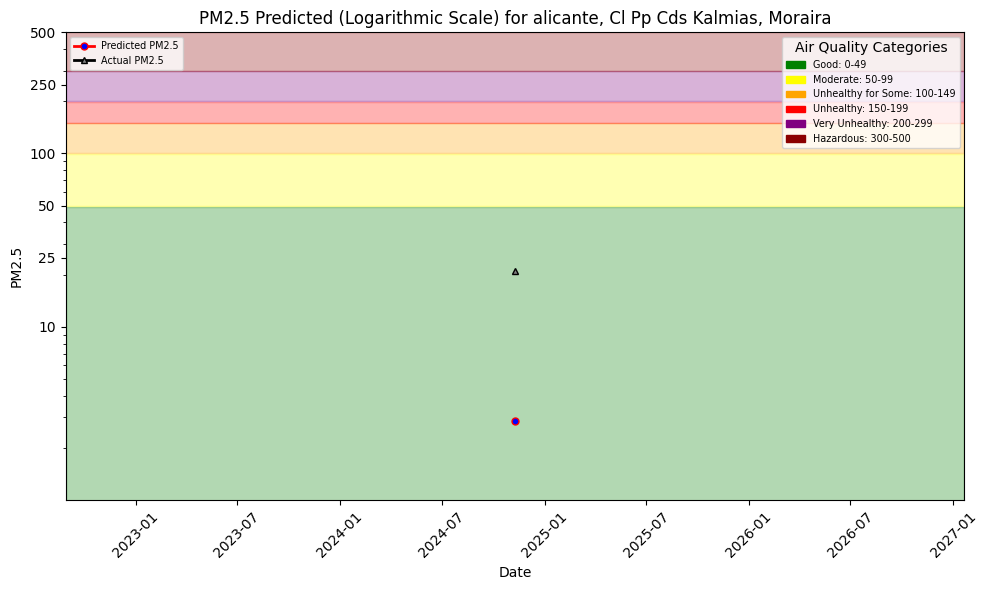

In [21]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---